<center><b>DIGHUM101</b></center>
<center>5-2: Topic Modeling</center>

---

# Learning objectives 

- Preprocessing text data
- Create an LDA topic model using `sklearn` and `gensim`
- Visualize and interpret a topic model using `pyLDAvis`

In [1]:
# Install new libraries if needed

# !pip install wordcloud
# !pip install pyldavis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 2.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 984.2 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of pyfume to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 17.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 1.8 MB/s eta 0:00:00
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20431 sha256=1e3fc3e21a056eeec34735622ac75e7dfe58953352a4687f22e6b72e1a535236
  Stored in directory: /Users/prashant/Library/Caches/pip/wheels/69/f5/e5/18ad53fe1ed6b2af9fad05ec052e4acbac8e92441df44bad2e
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3507 sha256=81441ed5ff61bdb760fc0aed0604addfff1a08be30fa925169a7989c43d80966
  St

In [4]:
# Import libraries

from collections import Counter # Count most common words
%matplotlib inline
import nltk # natural language toolkit
from nltk.corpus import stopwords
import numpy as np 
import os
import pandas as pd
import pyLDAvis # visualize our topic models!
# import re # regular expressions
# Preprocessing
import gensim
# Algorithms (unsupervised)
from sklearn.decomposition import LatentDirichletAllocation
# Tools to create our DTMs
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
# Visualize word clouds 
from wordcloud import WordCloud
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

# Topic modeling

There are many topic modeling algorithms, but we'll start with [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). This is a standard **unsupervised** machine learning text-mining tool that can be used to discover abstract "topics" contained within texts.

See [this cool animation](https://en.wikipedia.org/wiki/File:Topic_model_scheme.webm) on Wikipedia to get an idea about topic modeling works.


## Vocabulary

- **Topic Modeling:** A general class of statistical models that uncover abstract topics within a text. It uses the co-occurrence of words within documents, compared to their distribution across documents, to uncover these abstract themes. The output is a list of weighted words, which indicate the subject of each topic, and a weight distribution across topics for each document.
    
- **LDA:** Latent Dirichlet Allocation. A particular model for topic modeling. It does not take document order into account, unlike other topic modeling algorithms. Also see word2vec and BERT! (Week 5)

Like the rest of this class, the goal is not to learn everything about topic modeling. Instead, this notebook will provide you with some starter code to run some simple models with the idea that you can use this base of knowledge to explore further. Use the `sklearn` help files, Stack Overflow, and Google searching to review and learn more about what the code is doing and how to go further. 

Can you make this code work for your own data? Can you tweak the parameters to get better output?

# Create a dataframe from individual text files

You've gathered a bunch of text files, so now what? It is useful to get these files into a dataframe. Python does not make this terribly easy for the beginner, so use the boilerplate code below to help you.

Let's concatenate the eleven text files in the "Data/human-rights/" folder into a dataframe so we can manipulate that text like we have seen in the previous few notebooks.

In [5]:
# Where am I?
%pwd

'/Users/prashant/DIGHUM101-2024/Notebooks/Week5'

In [6]:
# Define a variable with the file path for the directory containing the text files
# Go two directories up (../../) 
# and into the Data directory
# then into the human-rights subdirectory
dir_path = os.listdir("../../Data/human-rights/")

# View the contents of this directory
dir_path

['sanmarino2014.txt',
 'tuvalu2013.txt',
 'kazakhstan2014.txt',
 'cotedivoire2014.txt',
 'fiji2014.txt',
 'bangladesh2013.txt',
 'turkmenistan2013.txt',
 'jordan2013.txt',
 'monaco2013.txt',
 'afghanistan2014.txt',
 'djibouti2013.txt']

In [8]:
# Designate an empty dictionary to store the filename and text as columns
for_dataframe = {}

# Loop through the directory of text files and open and read them
for file in dir_path:
    with open("../../Data/human-rights/" + file, "r", encoding="utf-8") as to_open:
         for_dataframe[file] = to_open.read()
            
# Create and append the dataframe with two columns - the file name and the text itself
human_rights = (pd.DataFrame.from_dict(for_dataframe, 
                                       orient = "index")
                .reset_index().rename(index = str, 
                                      columns = {"index": "File", 0: "Text"}))

In [9]:
human_rights

,File,Text
0,sanmarino2014.txt,\n United Nations \n A/HRC/28/9 \n \n \n\n Ge...
1,tuvalu2013.txt,\n United Nations \n A/HRC/24/8 \n \n \n\n G...
2,kazakhstan2014.txt,\n United Nations \n A/HRC/28/10 \n \n \n\n G...
3,cotedivoire2014.txt,\nDistr.: General 7 July 2014 English Original...
4,fiji2014.txt,\n United Nations \n A/HRC/28/8 \n \n \n\n Ge...
5,bangladesh2013.txt,\n United Nations \n A/HRC/24/12 \n \n \n\n ...
6,turkmenistan2013.txt,\n United Nations \n A/HRC/24/3 \n \n \n\n G...
7,jordan2013.txt,\nDistr.: General 6 January 2014 \nOriginal: E...
8,monaco2013.txt,\nDistr.: General 3 January 2014 English Origi...
9,afghanistan2014.txt,\nDistr.: General 4 April 2014 \nOriginal: Eng...


# Review - manipulate and explore text

In [13]:
# Check out text of one row to make sure it looks okay...
human_rights.iloc[0,1][:1000]

' \n United Nations \n A/HRC/28/9 \n \n \n\n General Assembly \n Distr.: General \n24 December 2014 \n \nOriginal: English \n \n\nHuman Rights Council \n\nTwenty-eighth session \nAgenda item 6 \nUniversal Periodic Review \n  Report of the Working Group on the Universal Periodic Review* \n * The annex to the present report is circulated as received. \n  San Marino \nContents \n Paragraphs Page \n  Introduction .............................................................................................................  1Ð4 3 \n I. Summary of the proceedings of the review process ................................................  5Ð77 3 \n  A. Presentation by the State under review ...........................................................  5Ð23 3 \n  B. Interactive dialogue and responses by the State under review ........................  24Ð77 6 \n II. Conclusions and/or recommendations .....................................................................  78Ð81 13 \n Annex \n  Composi

# Basic preprocessing

Preprocess the text! What else might you want to do that is not included here? Lemmatization? 

In [14]:
human_rights["Text_processed"] = human_rights["Text"].apply(gensim.utils.simple_preprocess)

human_rights["Text_processed"] 

0     [united, nations, hrc, general, assembly, dist...
1     [united, nations, hrc, general, assembly, dist...
2     [united, nations, hrc, general, assembly, dist...
3     [distr, general, july, english, original, engl...
4     [united, nations, hrc, general, assembly, dist...
5     [united, nations, hrc, general, assembly, dist...
6     [united, nations, hrc, general, assembly, dist...
7     [distr, general, january, original, english, g...
8     [distr, general, january, english, original, e...
9     [distr, general, april, original, english, gen...
10    [distr, general, july, english, original, engl...
Name: Text_processed, dtype: object

In [15]:
# Using gensim for preprocessing using .apply()
processed = human_rights["Text"].apply(gensim.utils.simple_preprocess)

# Stopword removal using NLTK stopword list and a lambda function
stop = stopwords.words('english')
no_stop = processed.apply(lambda x: [w for w in x if w not in stopwords.words('english')]) 

# Convert list back to str
human_rights["Text_processed"] = [' '.join(t) for t in no_stop]

In [16]:
human_rights

,File,Text,Text_processed
0,sanmarino2014.txt,\n United Nations \n A/HRC/28/9 \n \n \n\n Ge...,united nations hrc general assembly distr gene...
1,tuvalu2013.txt,\n United Nations \n A/HRC/24/8 \n \n \n\n G...,united nations hrc general assembly distr gene...
2,kazakhstan2014.txt,\n United Nations \n A/HRC/28/10 \n \n \n\n G...,united nations hrc general assembly distr gene...
3,cotedivoire2014.txt,\nDistr.: General 7 July 2014 English Original...,distr general july english original english fr...
4,fiji2014.txt,\n United Nations \n A/HRC/28/8 \n \n \n\n Ge...,united nations hrc general assembly distr gene...
5,bangladesh2013.txt,\n United Nations \n A/HRC/24/12 \n \n \n\n ...,united nations hrc general assembly distr gene...
6,turkmenistan2013.txt,\n United Nations \n A/HRC/24/3 \n \n \n\n G...,united nations hrc general assembly distr gene...
7,jordan2013.txt,\nDistr.: General 6 January 2014 \nOriginal: E...,distr general january original english general...
8,monaco2013.txt,\nDistr.: General 3 January 2014 English Origi...,distr general january english original english...
9,afghanistan2014.txt,\nDistr.: General 4 April 2014 \nOriginal: Eng...,distr general april original english general a...


In [18]:
human_rights['Text_processed'][0][:1000]

/var/folders/_h/fxjgx15j0pl36bhm_shwp1tc0000gn/T/ipykernel_15560/2782001119.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  human_rights['Text_processed'][0][:1000]


'united nations hrc general assembly distr general december original english human rights council twenty eighth session agenda item universal periodic review report working group universal periodic review annex present report circulated received san marino contents paragraphs page introduction summary proceedings review process presentation state review interactive dialogue responses state review ii conclusions recommendations annex composition delegation introduction working group universal periodic review established accordance human rights council resolution june held twentieth session october november review san marino held th meeting october delegation san marino headed pasquale valentini minister foreign affairs th meeting held october working group adopted report san marino january human rights council selected following group rapporteurs troika facilitate review san marino burkina faso chile china accordance paragraph annex resolution paragraph annex resolution following docume

In [19]:
# Get top-10 words

hr_str = ' '.join(human_rights['Text_processed'].tolist())
hr_tok = hr_str.split()
hr_freq = Counter(hr_tok)

# Print the 10 most common words
hr_df = pd.DataFrame(hr_freq.most_common(10), columns = ["Word", "Frequency"])
hr_df

,Word,Frequency
0,rights,1717
1,human,1204
2,women,725
3,international,691
4,national,683
5,made,639
6,recommendations,598
7,efforts,527
8,continue,453
9,violence,431


In [20]:
# Save to csv!
human_rights.to_csv('../../Data/human_rights.csv', index=False)

# Define a BOW model

In [22]:
# Define an empty bag (of words)
vectorizer = CountVectorizer()

# Use the .fit method to tokenize the text and learn the vocabulary
vectorizer.fit(human_rights["Text_processed"])

CountVectorizer()

# Create the DTM

Recall that a [document term matrix](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) displays term frequencies or TFIDF scores that occur across a collection of documents. We want to encode the documents into a [sparse matrix](https://sebastianraschka.com/faq/docs/bag-of-words-sparsity.html#:~:text=By%20definition%2C%20a%20sparse%20matrix,as%20a%20word%2Dcount%20vector.&text=Thus%2C%20if%20most%20of%20your,most%20likely%20sparse%20as%20well!) to represent the frequencies or TFIDF scores of each vocabulary word across the documents.

Again, the column headers could read **(document number, term)   frequency**

In [25]:
# Encode the documents
vector = vectorizer.transform(human_rights["Text_processed"])

print(type(vector))
print(vector.shape)
print(vector) 

<class 'scipy.sparse._csr.csr_matrix'>
(11, 5070)
  (0, 6)	1
  (0, 7)	1
  (0, 12)	4
  (0, 21)	1
  (0, 23)	1
  (0, 26)	1
  (0, 28)	1
  (0, 29)	15
  (0, 32)	5
  (0, 33)	2
  (0, 34)	4
  (0, 35)	1
  (0, 41)	6
  (0, 43)	4
  (0, 45)	2
  (0, 47)	8
  (0, 55)	9
  (0, 57)	3
  (0, 60)	2
  (0, 69)	1
  (0, 75)	2
  (0, 82)	2
  (0, 84)	1
  (0, 85)	1
  (0, 86)	2
  :	:
  (10, 4970)	1
  (10, 4973)	2
  (10, 4974)	1
  (10, 4978)	1
  (10, 4979)	1
  (10, 4988)	5
  (10, 4989)	1
  (10, 4994)	72
  (10, 4995)	15
  (10, 4997)	7
  (10, 4999)	3
  (10, 5003)	7
  (10, 5011)	1
  (10, 5012)	5
  (10, 5013)	2
  (10, 5014)	1
  (10, 5019)	1
  (10, 5020)	2
  (10, 5022)	2
  (10, 5023)	2
  (10, 5025)	1
  (10, 5031)	1
  (10, 5040)	1
  (10, 5045)	1
  (10, 5056)	1


In [39]:
# View as a multidimensional array before converting to data frame
# Rows are the documents, columns are the terms

print(vector.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]]


In [37]:
# Preview the terms

vectorizer.get_feature_names_out()[0:10] # older version of sklearn use get_feature_names()

array(['abasi', 'abdi', 'abdou', 'abduction', 'abdul', 'abdullah',
       'abide', 'abiding', 'abilities', 'ability'], dtype=object)

# Define a bigram bag of words

In [41]:
# Note we are entering regular expression as a token_pattern argument

bigram_vectorizer = CountVectorizer(ngram_range = (1,2),
                                    stop_words = "english",
                                    token_pattern = r'\b\w+\b', 
                                    min_df = 1)

bigram_vectorizer

CountVectorizer(ngram_range=(1, 2), stop_words='english',
                token_pattern='\\b\\w+\\b')

In [43]:
# Analyze string in the bigram bag of words

analyze = bigram_vectorizer.build_analyzer()
vocab = analyze(hr_str)

vocab[0:10]

['united',
 'nations',
 'hrc',
 'general',
 'assembly',
 'distr',
 'general',
 'december',
 'original',
 'english']

In [44]:
# Show the 20 most commons
freq = Counter(vocab)
stop_df = pd.DataFrame(freq.most_common(20), columns = ["Word", "Frequency"])
stop_df

,Word,Frequency
0,rights,1717
1,human,1204
2,human rights,1112
3,women,725
4,international,691
5,national,683
6,recommendations,598
7,efforts,527
8,continue,453
9,violence,431


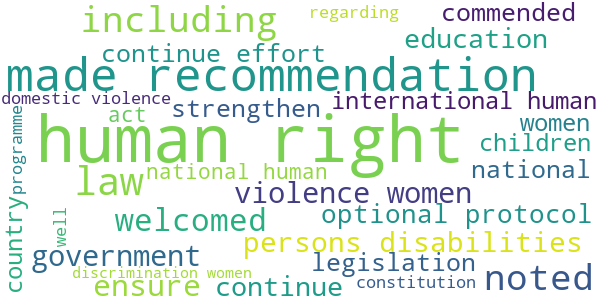

In [45]:
# Define a word cloud variable
cloud = WordCloud(background_color = "white", 
                  max_words = 30, 
                  contour_width = 5, 
                  width = 600, height = 300, 
                  random_state = 4)

# Process the word cloud
cloud.generate(hr_str)

# Visualize!
cloud.to_image()

Learn about using [custom colors here](https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html)

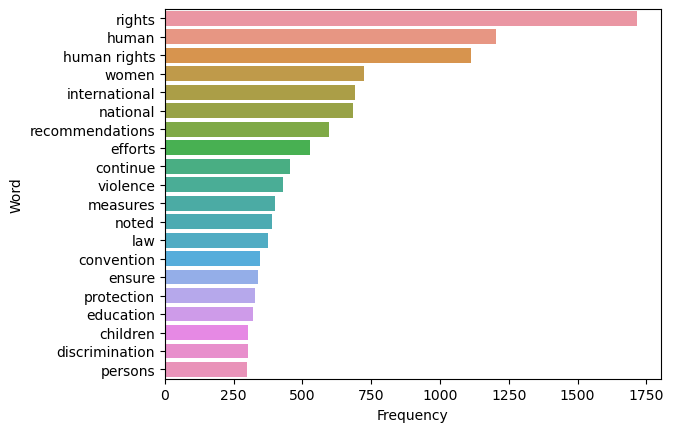

In [46]:
# Visualize word frequencies in a horizontal bar plot

sns.barplot(x = "Frequency",
            y = "Word",
            data = stop_df,
            orient = "h");

# Finally! Fit the topic model

The input to LDA should be a DTM.

In [47]:
# Predetermine the number of topics

n_topics = 10

In [48]:
# CountVectorizer to create the DTM, using some arguments to filter words!

tf_vectorizer = CountVectorizer(max_df = 0.9, # ignore terms that appear in more than 90% of the documents 
                                   max_features = 500) # using the 500 most-frequent words accross all documents 

# Fit
cv = tf_vectorizer.fit_transform(human_rights["Text_processed"])

[Check out this question](https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer) to learn more about the `max_df` and `min_df` arguments. 

Finally, let's run our LDA model! Remember that LDA is a probabilistic model that tries to estimate probability distributions for topics in documents and words in topics. We are using raw frequencies here but could also use TFIDF. This would increase the chance of rare words being sampled, making them have a stronger influence in topic assignment. Try it out if you feel like it!

In [49]:
# Instantiate our LDA model (this might take a minute or two)
lda = LatentDirichletAllocation(n_components = n_topics, 
                                max_iter = 20, # the maximum number of passes over the training data (aka epochs) 
                                random_state = 42) # setting random_state creates replicable results 
lda = lda.fit(cv)

In [50]:
# Here is a function to print out the top words for each topic in a pretty way:

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx+1))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [52]:
# Return the topics
tf_feature_names = tf_vectorizer.get_feature_names_out() # in older version you might have get_features_names()
print_top_words(lda, tf_feature_names, 20)


Topic #1:
jordan, refugees, constitutional, press, publications, jordanian, media, reform, reservations, recommendation, syrian, increased, strategies, penal, empowerment, independence, detention, websites, per, strategy

Topic #2:
te, dõivoire, djibouti, afghanistan, reconciliation, fgm, djiboutiõs, peace, strategy, community, reform, female, marriage, per, op, impunity, recommendation, afghan, death, cedaw

Topic #3:
tuvalu, water, treaties, sanitation, drinking, safe, community, technical, core, climate, rapporteur, change, constraints, police, youth, strategic, priorities, traditional, bill, peopleõs

Topic #4:
consultations, sex, priorities, significant, one, consideration, opinion, application, indicated, way, noting, help, corporal, reported, developments, acceding, important, immunities, lawyers, constitutional

Topic #5:
monaco, de, nationality, monegasque, des, principality, specific, police, recommendation, foreign, institution, said, procedure, conditions, tunisia, bill, a

In [61]:
panel = pyLDAvis.prepare(
    topic_term_dists=lda.components_,
    doc_topic_dists=lda.transform(cv),
    doc_lengths=cv.sum(axis=1).A1,
    vocab=tf_vectorizer.get_feature_names_out(),
    term_frequency=cv.sum(axis=0).A1,
    mds='tsne'  # method for dimensionality reduction - compare tsne to pcoa
)

pyLDAvis.display(panel)

# Interpreting PyLDAvis output
- Similar topics should appear close together on the plot; dissimilar topics should appear far apart. 
- The relative size of a topic's circle in the plot corresponds to the relative frequency of the topic in the corpus.

## Salience
When no topic is selected in the plot on the left, the right bar chart shows the top-30 most **salient** terms in the corpus. A term's saliency is a measure of both how frequent the term is in the corpus and how "distinctive" it is in distinguishing between different topics.

## Probability Vs Exclusivity 
When you select a particular topic, this bar chart changes to show the top-30 most "relevant" terms for the selected topic. The relevance metric is controlled by the parameter λ, which can be adjusted with a slider above the bar chart:

* Setting λ close to 1.0 (the default) will rank the terms according to their probability within the topic.
* Setting λ close to 0.0 will rank the terms according to their "distinctiveness" or "exclusivity" within the topic. This means that terms that occur only in this topic, and do not occur in other topics.

You can move the slider between 0.0 and 1.0 to weigh term probability and exclusivity.

# Using `gensim`

There's a lot of different packages in Python that allow you to do topic modeling. `gensim` is another. Let's run a similar topic model just to inspect the differences, and to see how much these choices matter for the output you get!


In [ ]:
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel

prep = [t.split() for t in human_rights["Text_processed"]]

# Create Dictionary - like "fit" using sklearn
dictionary = corpora.Dictionary(prep)

# filter extremes and assign new ids
dictionary.filter_extremes(no_above=0.9, keep_n=500)
dictionary.compactify() 

# Create Document-Term Matrix of our whole corpus (like "transform" using sklearn) 
corpus = [dictionary.doc2bow(text) for text in prep]


In [ ]:
# inspect a random ID in the dict for some word
dictionary.token2id['achieved']

In [ ]:
# first document, first 10 word IDs and their count
corpus[0][:10]

In [ ]:
# second document, first 10 word IDs and their count
corpus[1][:10]

In [ ]:
from gensim.models.ldamodel import LdaModel

lda_gensim = LdaModel(corpus=corpus,   # stream of document vectors or sparse matrix of shape
            id2word=dictionary,       # mapping from word IDs to words (for determining vocab size)
            num_topics=5,            # amount of topics
            random_state=42,         # seed to generate random state; useful for reproducibility
            passes=20,                 # amount of iterations/epochs 
            per_word_topics=False)    # computing most-likely topics for each word 

In [ ]:
import pyLDAvis.gensim_models as gensimvis

panel = gensimvis.prepare(lda_gensim, corpus, dictionary, mds="tsne")

pyLDAvis.display(panel)

# Challenge

1. What is a topic in LDA? 
2. What is the relevance metric lambda in the pyLDAvis plot?
3. What do you know about the eleven human rights documents we used to do this exercise? 
4. Why are all these topics similar in size in the left plot?
5. Plug in your own data! 

# Challenge 2

Read up on LDA and its visualizations by clicking the below links:
- https://www.objectorientedsubject.net/2018/08/experiments-on-topic-modeling-pyldavis/
- http://www.cs.columbia.edu/~blei/papers/ChaneyBlei2012.pdf
- https://shravan-kuchkula.github.io/topic-modeling/#lda-results
- https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html
- http://vis.stanford.edu/files/2012-Termite-AVI.pdf